100%|██████████| 39/39 [00:00<00:00, 3883.25it/s]


Skipping ./experiments/target_only_f2981d53e589ec50/fold0_kerry as no metrics.json
38
target_participant
kerry    38
Name: count, dtype: int64
mode
target_only    38
Name: count, dtype: int64
target_data_pct
0.125    8
0.250    8
0.010    8
1.000    7
0.500    7
Name: count, dtype: int64


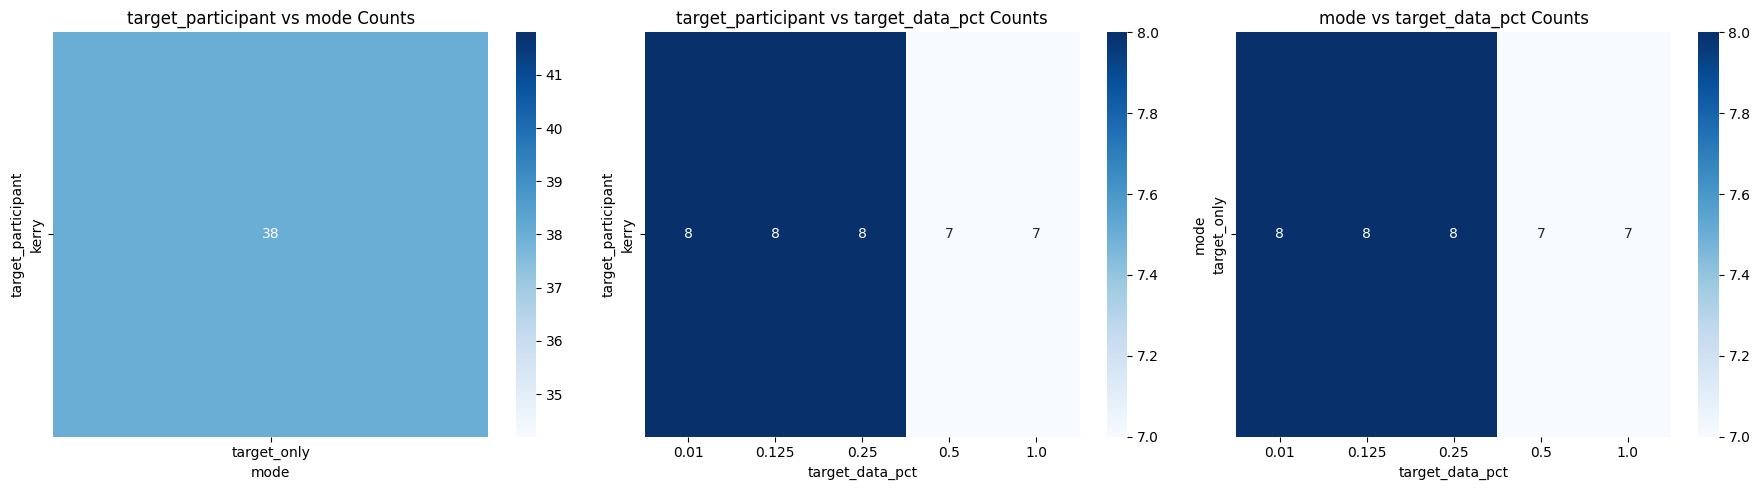

In [15]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1, plot_hyperparameter_counts, load_experiments_from_dir

experiments_dir = f'./experiments'

df = load_experiments_from_dir(experiments_dir, device='cuda')
print(len(df))
hyperparameters_to_plot = ['target_participant', 'mode','target_data_pct']
for hp in hyperparameters_to_plot:
    print(df[hp].value_counts())


def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

def get_base_val_f1(row):
    if row['mode'] == 'base':
        return row['target_val_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['target_val_f1'].iloc[0] if len(base_row) > 0 else None
    
df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['base_target_val_f1'] = df.apply(get_base_val_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']
df['relative_improvement'] = df['absolute_improvement'] / df['base_test_f1']
df['room_for_improvement'] = 1.0 - df['base_test_f1']
df['relative_to_room_for_improvement'] = df['absolute_improvement'] / df['room_for_improvement']

df['absolute_improvement_val'] = df['best_val_f1'] - df['base_target_val_f1']
df['relative_improvement_val'] = df['absolute_improvement_val'] / df['base_target_val_f1']
df['room_for_improvement_val'] = 1.0 - df['base_target_val_f1']
df['relative_to_room_for_improvement_val'] = df['absolute_improvement_val'] / df['room_for_improvement_val']

df = df[df['target_data_pct'] != .001]
plot_hyperparameter_counts(df, hyperparameters_to_plot)

Models trained on a population of individuals perform quite well within distribution (meaning on the individuals it was trained on)

In [16]:
df

,base_experiment_prefix,best_val_loss,best_val_loss_epoch,best_val_f1,best_val_f1_epoch,total_epochs,test_loss,test_f1,fold,device,...,base_test_f1,base_target_val_f1,absolute_improvement,relative_improvement,room_for_improvement,relative_to_room_for_improvement,absolute_improvement_val,relative_improvement_val,room_for_improvement_val,relative_to_room_for_improvement_val
0,None,0.164163,10,0.490105,0,100,0.193390,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,0.182432,8,0.490105,1,101,0.055663,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,0.175607,8,0.490105,1,101,0.057830,1.000000,0,1,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,0.164172,86,0.490105,1,101,0.419487,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,0.164460,102,0.490105,2,102,0.561517,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,None,0.165312,14,0.490105,0,100,0.292393,1.000000,0,1,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,None,0.183501,17,0.490105,13,113,0.051719,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,None,0.209331,113,0.490105,13,113,0.430526,0.497148,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,None,0.164229,16,0.490105,0,100,0.287504,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,None,0.172729,8,0.490105,7,107,0.044628,1.000000,0,0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 1.0)

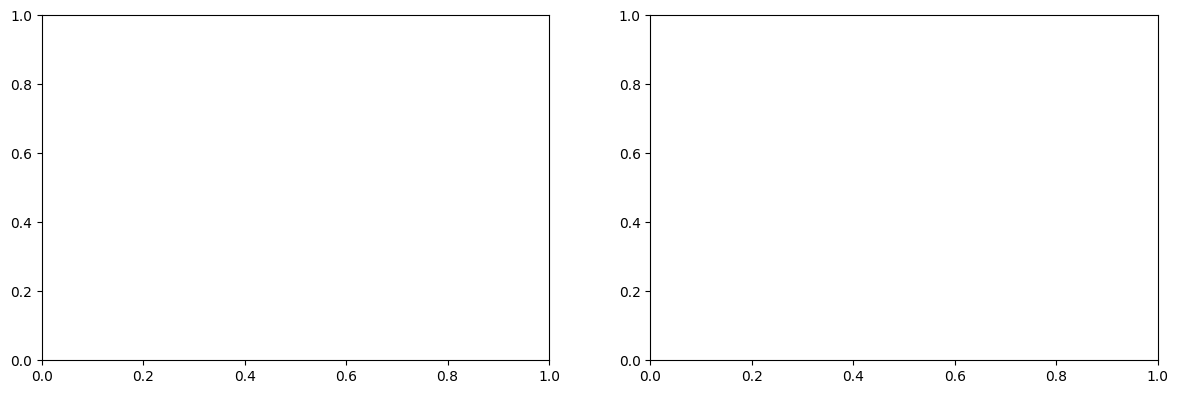

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df[df['mode'] == 'base'], y='best_val_f1', ax=ax[0])
sns.boxplot(data=df[df['mode'] == 'base'], x='target_participant', y='best_val_f1', ax=ax[1])

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

However, performance of population models on participants out of distribution varies widely

(0.0, 1.0)

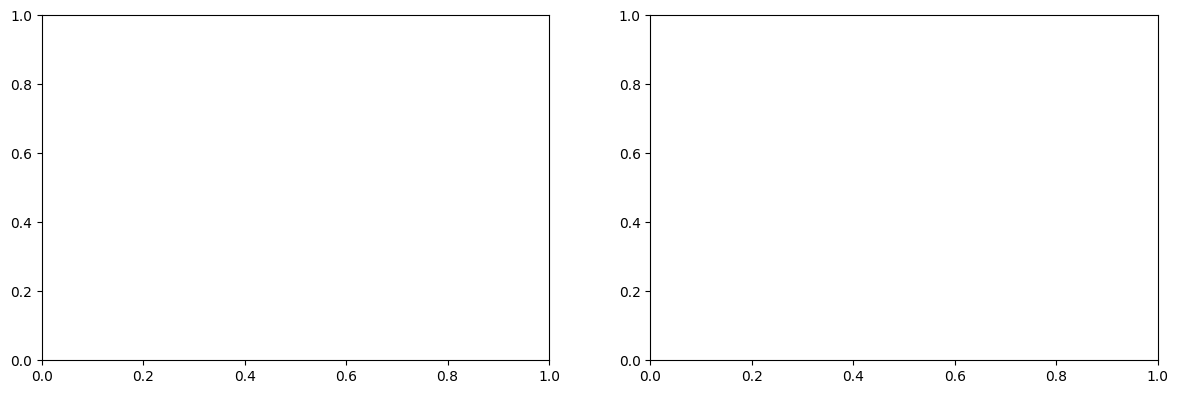

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df[df['mode'] == 'base'], y='test_f1', ax=ax[0])
sns.boxplot(data=df[df['mode'] == 'base'], x='target_participant', y='test_f1', ax=ax[1])

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

Here is the same plot with the performance of population models in distribution and out of distribution side by side

In [5]:
df_melted = df.melt(id_vars=['mode','target_participant'], value_vars=['best_val_f1','test_f1'])

<Axes: >

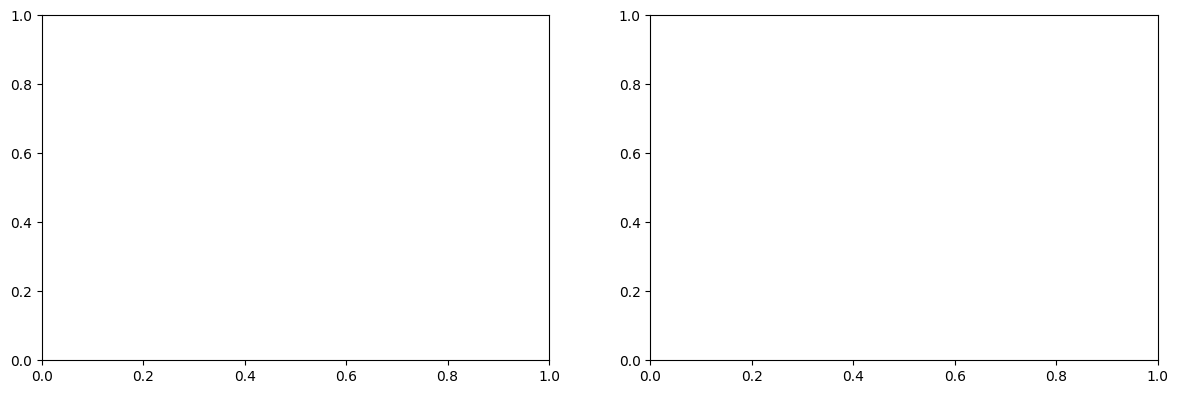

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df_melted[df_melted['mode'] == 'base'], y='value', hue='variable', ax=ax[0])
sns.boxplot(data=df_melted[df_melted['mode'] == 'base'], x='variable', y='value', hue='target_participant', ax=ax[1])

Our goal is to develop a method that performs better on individuals out of distribution. Idea: fine tune population model on data from the data.

Here is a plot of the performance of a base model and a fine tuned model on a target

<Axes: >

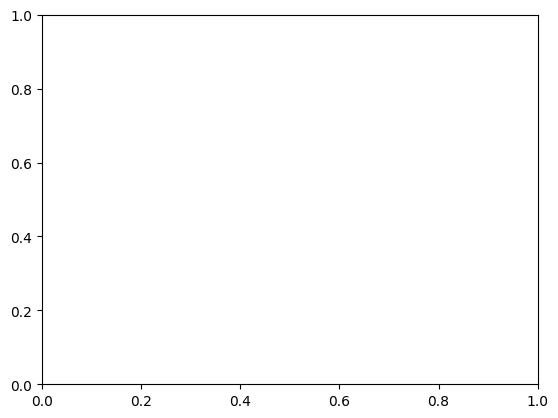

In [7]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='test_f1')

So, our method tightens performance distribution and shifts upward. By how much? Let's call the difference between the fine tuned model and the base model the absolute improvement.

<Axes: >

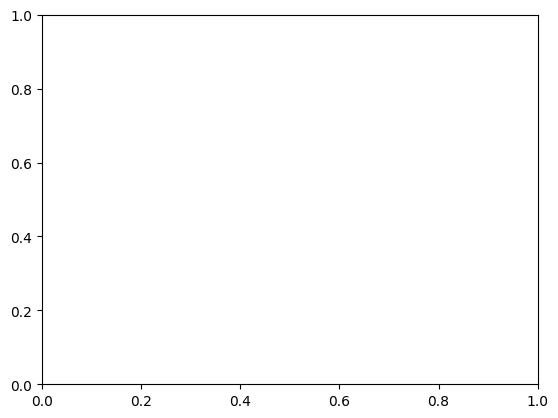

In [8]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['mode'] != 'base']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='absolute_improvement_val')

So there is the absolute improvement. Of course the base model doesn't improve over the base model, so that distribution is 0. But the target fine tuning model performance (across a distribution of random seeds and folds for cross validation) has significant absolute improvement. Now, this is ABSOLUTE improvement. What if a base model is ALREADY performing well? Then there is not much room for improvement. Let's define the absolute improvement as a proportion of that room for improvement as relative room for improvement.

<Axes: >

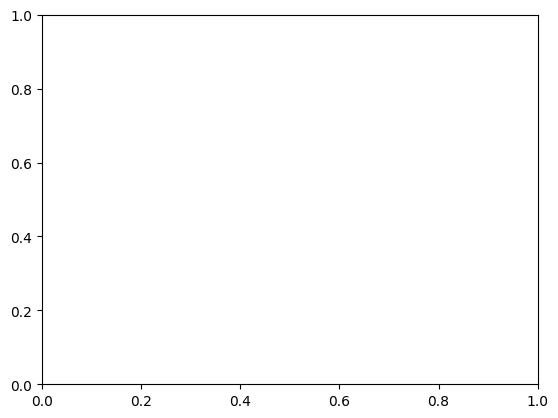

In [9]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['mode'] != 'base']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='relative_to_room_for_improvement_val')

So, on average we are recovering 40% of the relative room for improvement. For example, if a model starts with .5 f1, we increase that to .7. And if a base model performs with .9 f1, then we increase that to .94.

So, target only fine tuning improves signficantly over the base model, but that seems expected sort of. So why not just train a model from scratch only on the target's training set? Then you don't have to have a population model.

<Axes: xlabel='mode', ylabel='test_f1'>

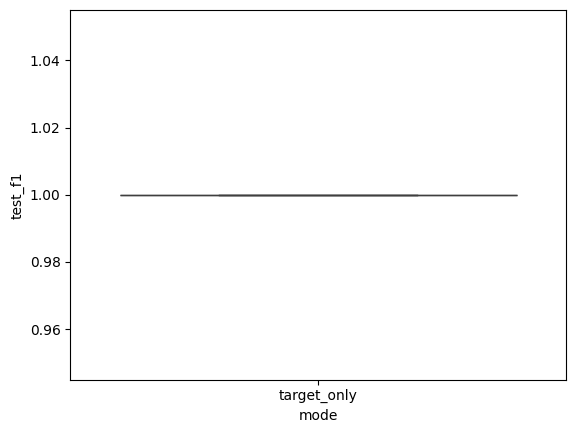

In [10]:
df_plot = df.copy()
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='test_f1')

Well, it may work to a satisfying performance, arguably better than the population model, but still worse than the fine tuned model. So there is a tradeoff between whether you have a population model and the performance you want to achieve. There is another parameter which is implicit here which is the _amount_ of target data you have available to you.

<Axes: xlabel='mode', ylabel='test_f1'>

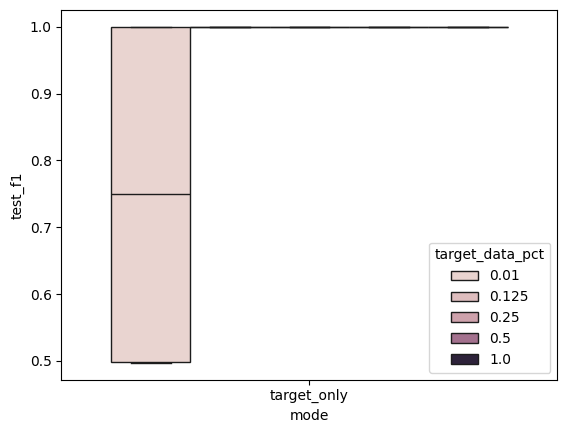

In [11]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'base']
sns.boxplot(data=df_plot,x='mode',y='test_f1',hue='target_data_pct')

<Axes: xlabel='target_data_pct', ylabel='test_f1'>

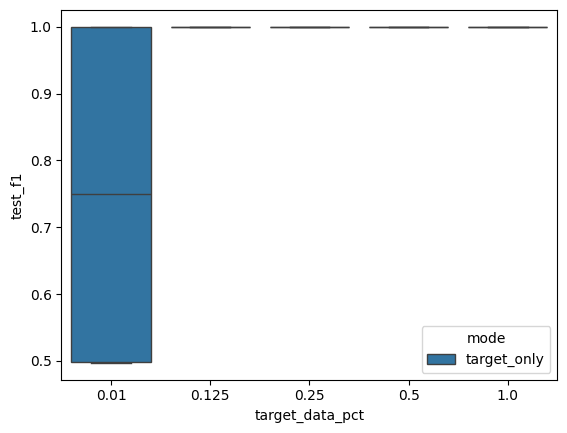

In [12]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

sns.boxplot(data=df_plot,x='target_data_pct',y='test_f1',hue='mode')

<Axes: xlabel='mode', ylabel='test_f1'>

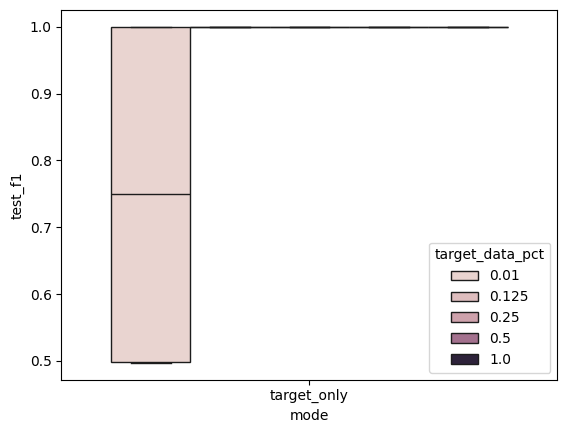

In [13]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

sns.boxplot(data=df_plot,x='mode',y='test_f1',hue='target_data_pct')

<Axes: xlabel='target_data_pct', ylabel='test_f1'>

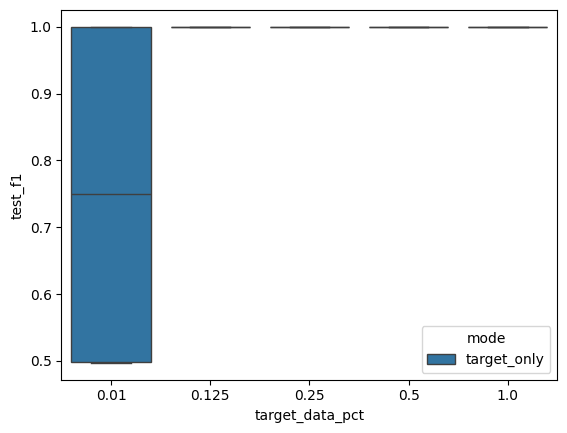

In [14]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.001, .01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

df_plot = df_plot[df_plot['fold'] == 0]
sns.boxplot(data=df_plot,x='target_data_pct',y='test_f1',hue='mode')